# <center> <font face="Times New Roman"> Analysis of Bird Migration </font></center>

<center> <font face="Times New Roman"> Gracy Whelihan, vgw3869@nyu.edu </font></center> 
<center> <font face="Times New Roman"> Sheeran Yan, zy2053@nyu.edu </font></center>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()
%matplotlib inline

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'statsmodels'

## <font face="Times New Roman">Read Full Data from 2000 to 2021</font>

**<font face="Times New Roman">Read data from text file</font>**  

In [3]:
# main data from year 2018 to 2021
txt_migration_total = open("data/ebird_US-NY__total.txt", "r")

**<font face="Times New Roman">Parse data from text file line by line</font>**

In [4]:
dict_migration_total = dict()
for line in txt_migration_total:
    line_list = line.split("\t")
    if line_list != ['\n'] and len(line_list) > 2: 
        dict_migration_total[line_list[0]] = line_list[1:-1]

**<font face="Times New Roman">Create DataFrame</font>**

In [5]:
df_migration_total = pd.DataFrame(dict_migration_total)
df_migration_total.rename(columns={'': 'week'}, inplace=True)

**<font face="Times New Roman">Data preprocessing</font>**

In [6]:
# preprocess week
for i in range(len(df_migration_total.week)):
    if df_migration_total.week.iloc[i] == '':
        preprocessed_data = df_migration_total.week.iloc[i - 1].split('_')[0] + '_' + str(i % 4 + 1)
        df_migration_total.week.iloc[i] = preprocessed_data
    else:
        df_migration_total.week.iloc[i] = df_migration_total.week.iloc[i] + '_' + '1'

In [7]:
# lower column name 
df_migration_total.columns = [
    col.lower().strip() for col in df_migration_total.columns
]

# set month_week as index
df_migration_total.set_index('week', inplace=True)

# coerce type string to type float
df_migration_total = df_migration_total.astype(float)

In [8]:
df_migration_total.shape

(48, 726)

There were only 48 obervations per year or four times per week without specified date.  
In further data processing, we assume that four observations within a month are fixed on 7th, 14th, 21st and 28th.

In [9]:
df_migration_total.head()

,sample size:,black-bellied whistling-duck,bar-headed goose,emperor goose,snow goose,ross's goose,snow x ross's goose (hybrid),snow/ross's goose,graylag goose,swan goose,...,rose-breasted/black-headed grosbeak,blue grosbeak,indigo bunting,painted bunting,passerina sp.,dickcissel,saffron finch,lined seedeater,passerine sp.,bird sp.
week,,,,,,,,,,,,,,,,,,,,,
Jan_1,37552.0,0.0,0.0,0.0,0.015259,0.001278,0.000107,0.000027,0.000346,0.000000,...,0.0,0.0,0.000000,0.002583,0.0,0.000586,0.0,0.0,0.002769,0.001198
Jan_2,28892.0,0.0,0.0,0.0,0.015818,0.002457,0.000000,0.000069,0.000554,0.000104,...,0.0,0.0,0.000035,0.000762,0.0,0.000000,0.0,0.0,0.002631,0.001454
Jan_3,28728.0,0.0,0.0,0.0,0.018101,0.000940,0.000070,0.000035,0.000696,0.000070,...,0.0,0.0,0.000000,0.000174,0.0,0.000278,0.0,0.0,0.002437,0.001497
Jan_4,36388.0,0.0,0.0,0.0,0.015637,0.000330,0.000028,0.000028,0.000660,0.000028,...,0.0,0.0,0.000000,0.000192,0.0,0.000330,0.0,0.0,0.002886,0.001731
Feb_1,24973.0,0.0,0.0,0.0,0.008689,0.000440,0.000000,0.000000,0.000521,0.000040,...,0.0,0.0,0.000000,0.000080,0.0,0.000040,0.0,0.0,0.002683,0.001602


In [10]:
birds = df_migration_total.columns[1:]
birds

Index(['black-bellied whistling-duck', 'bar-headed goose', 'emperor goose',
       'snow goose', 'ross's goose', 'snow x ross's goose (hybrid)',
       'snow/ross's goose', 'graylag goose', 'swan goose',
       'graylag x swan goose (hybrid)',
       ...
       'rose-breasted/black-headed grosbeak', 'blue grosbeak',
       'indigo bunting', 'painted bunting', 'passerina sp.', 'dickcissel',
       'saffron finch', 'lined seedeater', 'passerine sp.', 'bird sp.'],
      dtype='object', length=725)

## <font face="Times New Roman">Read Data Year by Year</font>

**<font face="Times New Roman">Encapsulate reading data functionalities into a single function</font>**  

In [11]:
def read_data(path):
    """
    Read data from text file and return a structured dataframe.
    :param path: str; string of the file path.
    :return: pd.DataFrame; 
    """
    # Read data from text
    txt = open(path, "r")
    dict_txt = dict()
    for line in txt:
        line_list = line.split("\t")
        if line_list != ['\n'] and len(line_list) > 2: 
            dict_txt[line_list[0]] = line_list[1:-1]
            
    # Create dataframe
    df = pd.DataFrame(dict_txt)
    df.rename(columns={'': 'week'}, inplace=True)
    
    # Data preprocessing
    for i in range(len(df.week)):
        if df.week.iloc[i] == '':
            preprocessed_data = df.week.iloc[i - 1].split('_')[0] + '_' + str(i % 4 + 1)
            df.week.iloc[i] = preprocessed_data
        else:
            df.week.iloc[i] = df.week.iloc[i] + '_' + '1'
    
    # Add datetime index based on the # of week within a month
    year = path.split("__")[1].split("_")[0]
    df["date"] = pd.to_datetime(pd.Series(
        [f'{year} {month_week.split("_")[0]} {eval(month_week.split("_")[1]) * 7}' for month_week in df.week]
    ))
    df.set_index('date', inplace=True)
    
    # Other processing methods
    df.columns = [col.lower().strip() for col in df.columns]
    col_float = [col for col in df.columns if col != "week"]
    df[col_float] = df[col_float].astype(float)
    
    return df

In [12]:
# Read data into a dictionary
dict_df = dict()

# i.e. ebird_US-NY__2000_2001.txt
for year in range(2000, 2022):
    dict_df[str(year) + "_" + str(year + 1)] = read_data(f"data/ebird_US-NY__{year}_{year + 1}.txt")

In [13]:
dict_df["2000_2001"].head()

,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,summer tanager,scarlet tanager,western tanager,northern cardinal,rose-breasted grosbeak,blue grosbeak,indigo bunting,dickcissel,passerine sp.,bird sp.
date,,,,,,,,,,,,,,,,,,,,,
2000-01-07,Jan_1,150.0,0.020000,0.0000,0.0,0.000000,0.0,0.093333,0.0,0.0,...,0.0,0.0,0.0,0.360000,0.0,0.0,0.0,0.0,0.000000,0.0000
2000-01-14,Jan_2,111.0,0.018018,0.0015,0.0,0.000000,0.0,0.090090,0.0,0.0,...,0.0,0.0,0.0,0.306306,0.0,0.0,0.0,0.0,0.009009,0.0015
2000-01-21,Jan_3,99.0,0.010101,0.0000,0.0,0.000000,0.0,0.101010,0.0,0.0,...,0.0,0.0,0.0,0.303030,0.0,0.0,0.0,0.0,0.000000,0.0000
2000-01-28,Jan_4,137.0,0.036496,0.0000,0.0,0.001500,0.0,0.116788,0.0,0.0,...,0.0,0.0,0.0,0.248175,0.0,0.0,0.0,0.0,0.014599,0.0000
2000-02-07,Feb_1,124.0,0.024193,0.0000,0.0,0.008065,0.0,0.129032,0.0,0.0,...,0.0,0.0,0.0,0.233871,0.0,0.0,0.0,0.0,0.000000,0.0000


**<font face="Times New Roman">Concatenate all the yearly data together to a single dataframe</font>**  

In [14]:
df_migration_yoy = pd.DataFrame()
for key in dict_df.keys():
    df_migration_yoy = pd.concat([df_migration_yoy, dict_df[key]])
    
display(df_migration_yoy.head())
display(df_migration_yoy.tail())

,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,redhead x lesser scaup (hybrid),columba sp.,king x clapper rail (hybrid),bermuda petrel,zone-tailed hawk,long-eared/short-eared owl,sulphur-bellied flycatcher,yellow-crowned bishop,dark-eyed junco/pine warbler,rose-breasted/black-headed grosbeak
date,,,,,,,,,,,,,,,,,,,,,
2000-01-07,Jan_1,150.0,0.020000,0.0000,0.0,0.000000,0.0,0.093333,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-14,Jan_2,111.0,0.018018,0.0015,0.0,0.000000,0.0,0.090090,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-21,Jan_3,99.0,0.010101,0.0000,0.0,0.000000,0.0,0.101010,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-28,Jan_4,137.0,0.036496,0.0000,0.0,0.001500,0.0,0.116788,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-07,Feb_1,124.0,0.024193,0.0000,0.0,0.008065,0.0,0.129032,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,redhead x lesser scaup (hybrid),columba sp.,king x clapper rail (hybrid),bermuda petrel,zone-tailed hawk,long-eared/short-eared owl,sulphur-bellied flycatcher,yellow-crowned bishop,dark-eyed junco/pine warbler,rose-breasted/black-headed grosbeak
date,,,,,,,,,,,,,,,,,,,,,
2021-11-28,Nov_4,6171.0,0.017987,0.001620,0.000162,0.002431,0.000324,0.054772,0.0,0.009723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-07,Dec_1,4959.0,0.015124,0.000403,0.000000,0.005646,0.000403,0.065739,0.0,0.003831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-14,Dec_2,4668.0,0.028492,0.000214,0.000000,0.003856,0.000643,0.059983,0.0,0.005784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-21,Dec_3,6228.0,0.015735,0.000000,0.000000,0.003211,0.000161,0.046885,0.0,0.002248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-28,Dec_4,8386.0,0.015144,0.001500,0.000000,0.002623,0.000715,0.056404,0.0,0.004293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <font face="Times New Roman">Statistics throughout 20 years</font>

**<font face="Times New Roman">Statistical Description</font>**   
  
[Checklist](https://support.ebird.org/en/support/solutions/articles/48000948655-ebird-glossary#anchorC): eBird checklists are aggregated lists of the birds you identified while birding, plus effort data like duration and distance traveled during that birding event.   
  
[Complete checklist](https://support.ebird.org/en/support/solutions/articles/48000948655-ebird-glossary#anchorC): an eBird checklist that includes all the birds you identified as best you could while birding (that doesn’t exclude species or report only highlights). Complete checklists are extremely valuable to research and conservation in eBird.  
  
[Frequency](https://support.ebird.org/en/support/solutions/articles/48000948655-ebird-glossary#anchorF): how often a species is reported on complete checklists within a specified date range and region, measured by percent of checklists reporting the species.

In [15]:
describe_total = df_migration_total.describe()
describe_total

,sample size:,black-bellied whistling-duck,bar-headed goose,emperor goose,snow goose,ross's goose,snow x ross's goose (hybrid),snow/ross's goose,graylag goose,swan goose,...,rose-breasted/black-headed grosbeak,blue grosbeak,indigo bunting,painted bunting,passerina sp.,dickcissel,saffron finch,lined seedeater,passerine sp.,bird sp.
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,4.800000e+01,48.000000,48.000000,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.000000
mean,32168.666667,0.000569,0.000036,0.000039,0.009886,0.000598,0.000016,0.000090,0.000394,0.000133,...,8.020833e-07,0.000833,0.032231,0.000283,3.458333e-07,0.001203,0.000005,0.000009,0.004737,0.002263
std,11150.947649,0.000940,0.000217,0.000220,0.011103,0.000791,0.000038,0.000303,0.000266,0.000359,...,5.556996e-06,0.000995,0.043941,0.000741,2.396004e-06,0.001576,0.000019,0.000027,0.002656,0.000627
min,16868.000000,0.000000,0.000000,0.000000,0.000584,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.002076,0.001198
25%,24947.500000,0.000000,0.000000,0.000000,0.002145,0.000000,0.000000,0.000000,0.000239,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000144,0.000000,0.000000,0.002876,0.001800
50%,28945.500000,0.000000,0.000000,0.000000,0.006999,0.000319,0.000000,0.000000,0.000336,0.000036,...,0.000000e+00,0.000470,0.004558,0.000000,0.000000e+00,0.000527,0.000000,0.000000,0.003364,0.002177
75%,35631.250000,0.000811,0.000000,0.000000,0.015311,0.001035,0.000000,0.000037,0.000485,0.000065,...,0.000000e+00,0.001320,0.055038,0.000142,0.000000e+00,0.001605,0.000000,0.000000,0.005946,0.002630
max,61022.000000,0.003549,0.001500,0.001500,0.052349,0.003242,0.000198,0.001500,0.001329,0.001500,...,3.850000e-05,0.004019,0.121728,0.003616,1.660000e-05,0.007203,0.000121,0.000114,0.011468,0.004140


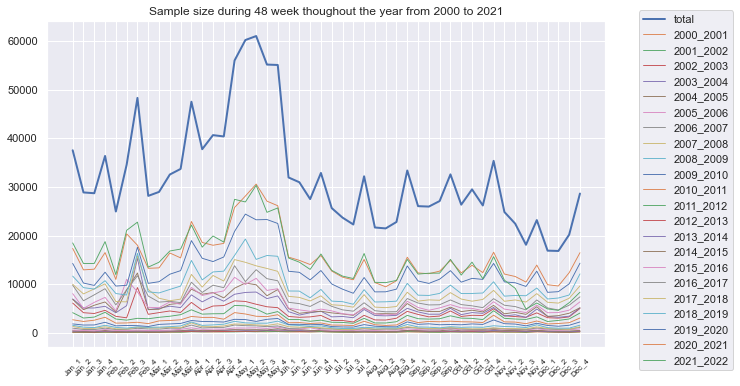

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df_migration_total["sample size:"], label="total", linewidth=2.0)

for key in dict_df.keys():
    plt.plot(
        dict_df[key].reset_index().set_index("week").drop("date", axis=1)["sample size:"], label=key, linewidth=0.9
    )

plt.title("Sample size during 48 week thoughout the year from 2000 to 2021", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.xticks(fontsize=8, rotation=45)
plt.show()

Spring especially April and May are the best months for birding, pleasant weather is one of the most important reason leads to birds' active ativities.

**<font face="Times New Roman">Easiest and hardest birds to spot</font>**

In [18]:
freq_sort_total = df_migration_total.iloc[:, 1:].mean(axis=0).sort_values()
print(f"Top 5 easiest birds to spot. \n\n{freq_sort_total.iloc[-5:]}")
print("\n")
print(f"Top 5 rarest birds to spot.\n\n{freq_sort_total.iloc[:5]}")

Top 5 easiest birds to spot. 

mourning dove             0.382968
black-capped chickadee    0.384682
american robin            0.428848
northern cardinal         0.442445
blue jay                  0.468619
dtype: float64


Top 5 rarest birds to spot.

passerina sp.               3.458333e-07
laughing/franklin's gull    3.770833e-07
south african shelduck      3.791667e-07
pheasant sp.                4.312500e-07
columba sp.                 4.375000e-07
dtype: float64


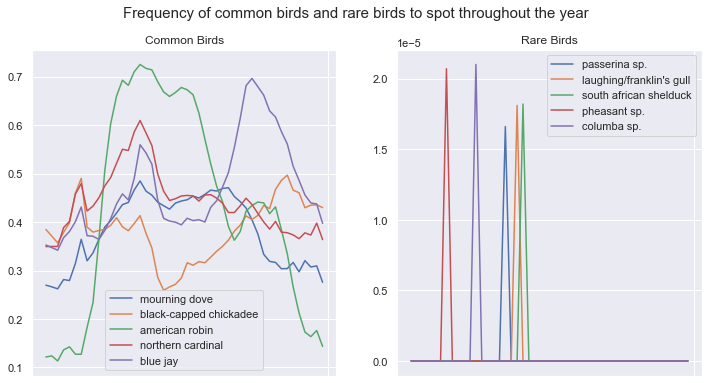

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Frequency of common birds and rare birds to spot throughout the year", fontsize=15)

for common_bird in freq_sort_total.iloc[-5:].index:
    axes[0].plot(df_migration_total[common_bird], label=common_bird)
axes[0].set_title('Common Birds', fontsize=12)
axes[0].set_xticks('')
axes[0].legend()

for rare_bird in freq_sort_total.iloc[:5].index:
    axes[1].plot(df_migration_total[rare_bird], label=rare_bird)
axes[1].set_title('Rare Birds', fontsize=12)
axes[1].set_xticks('')
axes[1].legend()

plt.show()

From the above data and visualization, we can see frequencies of those species are different from each other: rare birds have frequency almost equal to 0, whereas common birds have a very high probability to spot.   
At the meantime, they also share some similar patterns: most of their frequencies peaked during the Spring, which is obvious that birds activites are more active in Spring.  
Some of them even have two peaks, for example "Blue Jay": Its activity peaked during Fall besides Spring, this also shows the that this type of bird will have a large-scale migration before winter in order to prepare for the upcoming cold weather and reproduction in the next year.  

**<font face="Times New Roman">Correlation Matrix</font>**  
In order to check if there are any correlation between different birds' activities, we picked first ten species for visualizations.  

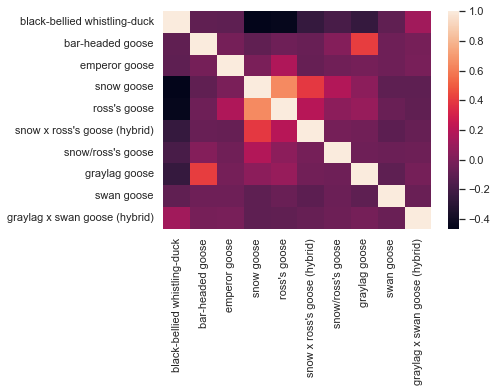

In [25]:
# calculate the correlation matrix for the first 20 species
corr = df_migration_total.iloc[:, 1:10 + 1].corr()

# plot the heatmap
sns.heatmap(
    corr, 
    xticklabels=corr.columns,
    yticklabels=corr.columns
)
plt.show()

Some of them have very high correlation, while others don't. We think this is because the magnitude of the data.   

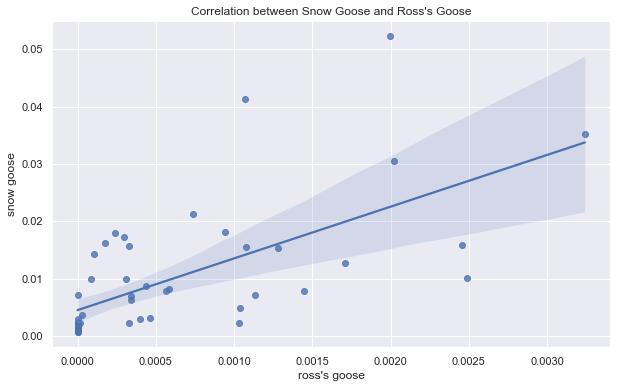

In [28]:
plt.figure(figsize=(10, 6))
sns.regplot(y=df_migration_total["snow goose"], x=df_migration_total["ross's goose"])
plt.title("Correlation between Snow Goose and Ross's Goose")
plt.show()

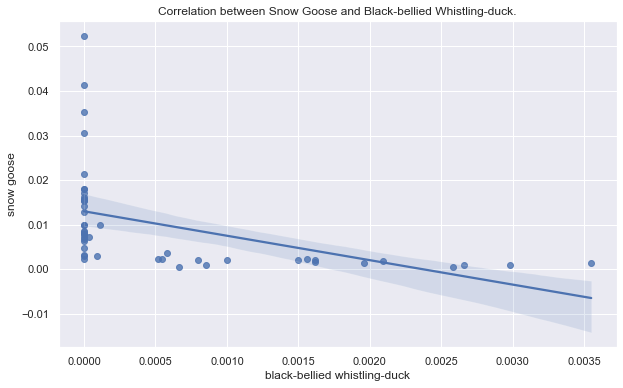

In [29]:
plt.figure(figsize=(10, 6))
sns.regplot(y=df_migration_total["snow goose"], x=df_migration_total["black-bellied whistling-duck"])
plt.title("Correlation between Snow Goose and Black-bellied Whistling-duck.")
plt.show()

There is an significant correlation between Snow Goose and Ross's Goose, and there is no correlation between Snow Goose and Black-bellied Whistling-Duck.  

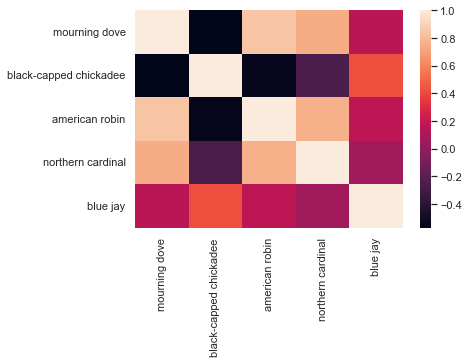

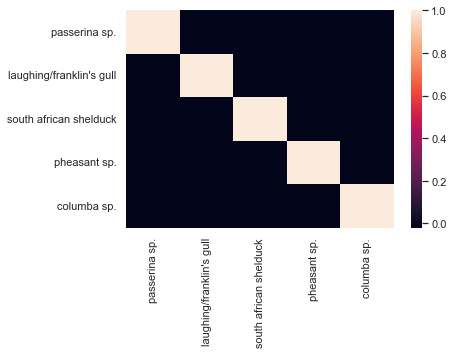

In [30]:
# calculate the correlation matrix for the rarest and easiest birds to spot.
col_top_birds = [col for col in freq_sort_total.iloc[-5:].index]
col_bot_birds = [col for col in freq_sort_total.iloc[:5].index]
corr_top = df_migration_total[col_top_birds].corr()
corr_bot = df_migration_total[col_bot_birds].corr()

sns.heatmap(
    corr_top, 
    xticklabels=corr_top.columns,
    yticklabels=corr_top.columns, 
)
plt.show()

sns.heatmap(
    corr_bot, 
    xticklabels=corr_bot.columns,
    yticklabels=corr_bot.columns,
)
plt.show()

Magnitude and number of data may lead to this problem, it is hard to analyze their similarity using only 48 observations with frequency almost equal to 0.

## <font face="Times New Roman">Statistics Year by Year</font>  

**<font face="Time New Roman">Plot the time series</font>**

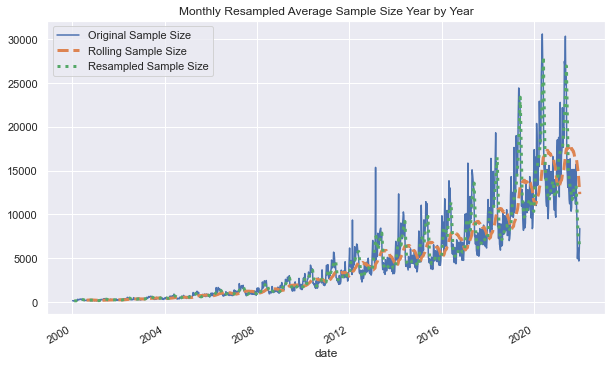

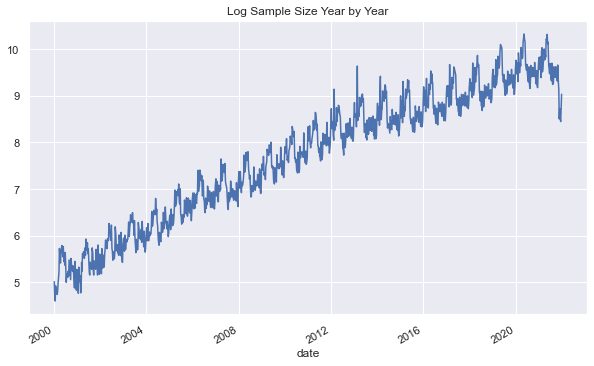

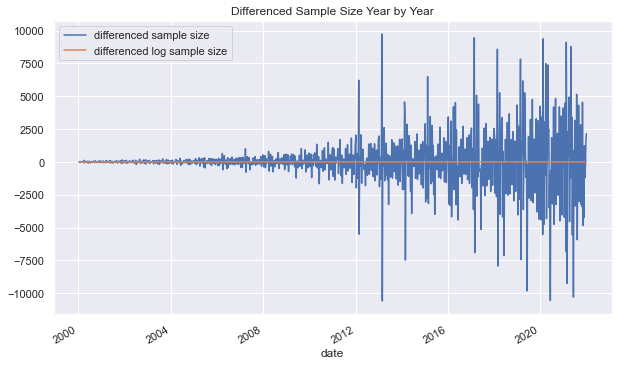

<Figure size 432x288 with 0 Axes>

In [38]:
# Original data
df_migration_yoy["sample size:"].plot(
    title="Sample Size Year by Year",
    label="Original Sample Size",
    figsize=(10, 6),
    legend=True
)
df_migration_yoy["sample size:"].rolling(30).mean().plot(
    title="Monthly Rolling Average Sample Size Year by Year",
    label="Rolling Sample Size",
    linestyle="--",
    linewidth=3,
    figsize=(10, 6),
    legend=True
)
df_migration_yoy["sample size:"].resample("M").mean().plot(
    title="Monthly Resampled Average Sample Size Year by Year",
    label="Resampled Sample Size",
    linestyle=":",
    linewidth=3,
    figsize=(10, 6),
    legend=True
)
plt.show()
plt.clf()

# Logarithmic data
df_migration_yoy["log sample size"] = np.log(df_migration_yoy["sample size:"])
df_migration_yoy["log sample size"].plot(
    title="Log Sample Size Year by Year",
    figsize=(10, 6)
)
plt.show()
plt.clf()

# differenced data
df_migration_yoy["differenced sample size"] = df_migration_yoy["sample size:"].diff()
df_migration_yoy["differenced sample size"].plot(
    title="Differenced Sample Size Year by Year",
    figsize=(10, 6), legend=True
)
df_migration_yoy["differenced log sample size"] = df_migration_yoy["log sample size"].diff()
df_migration_yoy["differenced log sample size"].plot(figsize=(10, 6), legend=True)
plt.show()
plt.clf()

From the above visualization we can see the original time series is exponential and not stationary, we used different aggragation methods to smooth the original data. 
Besides, we also used difference method to check if it could be stationary after transformation.  
Differenced data after logarithmic transformation is the most stationary one.  

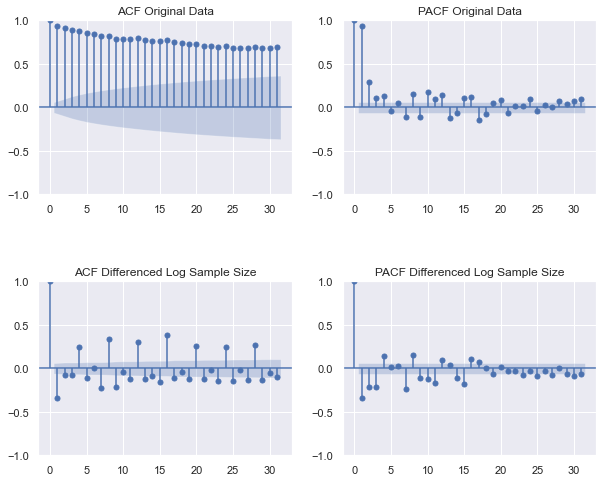

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5)

plot_acf(df_migration_yoy["sample size:"], ax=ax[0][0])
ax[0][0].set_title('ACF Original Data')
plot_pacf(df_migration_yoy["sample size:"], ax=ax[0][1], method='ywm')
ax[0][1].set_title('PACF Original Data')

plot_acf(df_migration_yoy["differenced log sample size"].dropna(), ax=ax[1][0])
ax[1][0].set_title('ACF Differenced Log Sample Size')
plot_pacf(df_migration_yoy["differenced log sample size"].dropna(), ax=ax[1][1], method='ywm')
ax[1][1].set_title('PACF Differenced Log Sample Size')

plt.show()

From the ACF and PACF plot of the original data, it shows a significant autocorrelation which means it is not stationary.  
From the ACF of the differenced logarithmic data, it shows a periodicity every four lags (every month). The PACF plot shows that only after 15 lags can the autocorrelation be diminished. It is still not stationary.

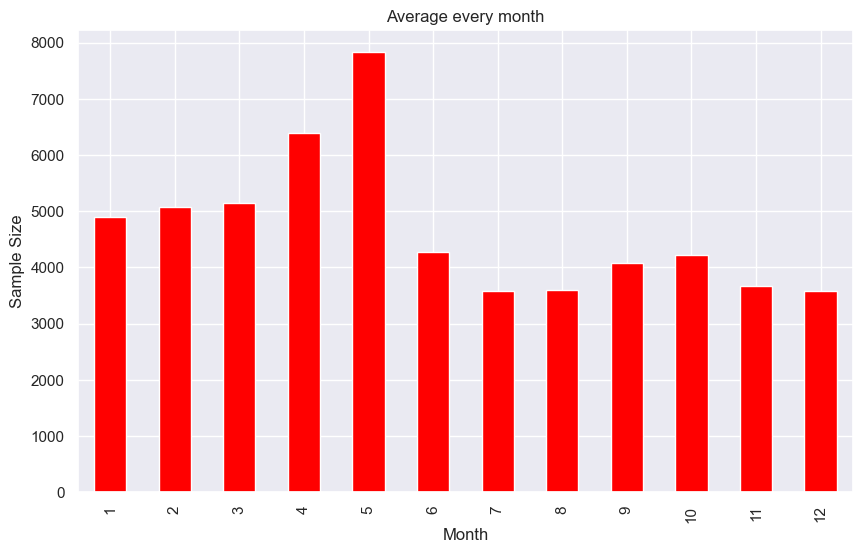

In [22]:
# df_migration_yoy["sample size:"].groupby(df_migration_yoy.index.month).mean().plot(figsize=(10, 6), title="Average every month");

df_migration_yoy["sample size:"].groupby(df_migration_yoy.index.month).mean().plot.bar(figsize=(10, 6), title= "Average every month", 
                                                                                       color = "red", 
                                                                                      ylabel = "Sample Size",
                                                                                        xlabel = "Month");


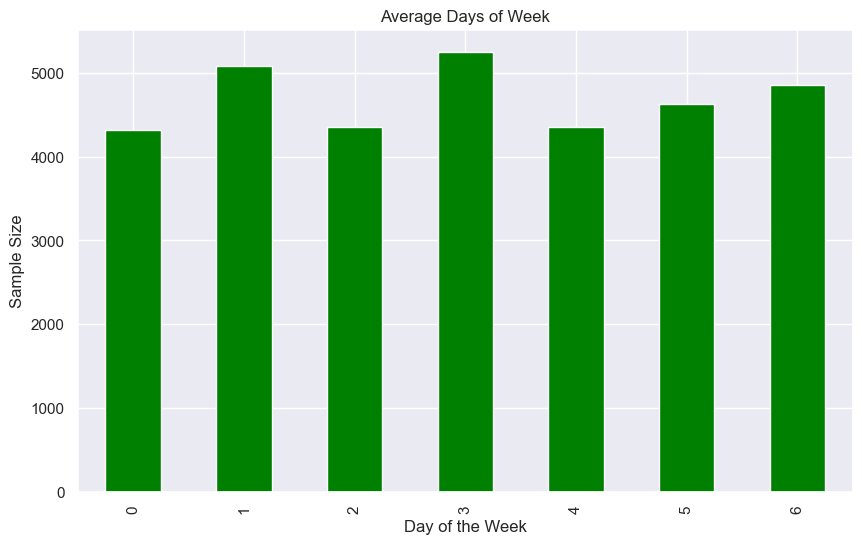

In [21]:
# df_migration_yoy["sample size:"].groupby(df_migration_yoy.index.dayofweek).mean().plot(figsize=(10, 6), title="Average Days of Week");

df_migration_yoy["sample size:"].groupby(df_migration_yoy.index.dayofweek).mean().plot.bar(figsize=(10, 6),
                                                                                           title = 'Average Days of Week', 
                                                                                           color = "Green",
                                                                                            ylabel = "Sample Size",
                                                                                           xlabel = "Day of the Week",
                                                                                          );



From the plot 'Average every month', birds' activity peaked in May (another in October),  
From the plot 'Average Days of Week', there are no specific logic behind peaks and troughs.

## <font face="Times New Roman">Clusters</font>  
In order to capture potential structures of birds' migration, we used k-means assuming three clusters.

**<font face="Time New Roman">Clustering from a time series point of view</font>**  

In [98]:
# dropna for clustering
df_cluster = df_migration_yoy.iloc[:, 1:][birds].dropna(axis=1)

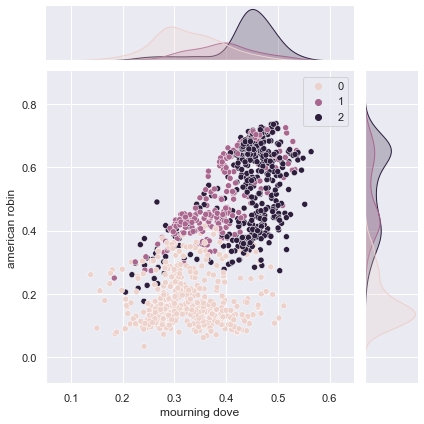

In [68]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_cluster)
sns.jointplot(data=df_cluster, x="mourning dove", y="american robin", hue=kmeans.labels_) #, kind="kde")
plt.show()

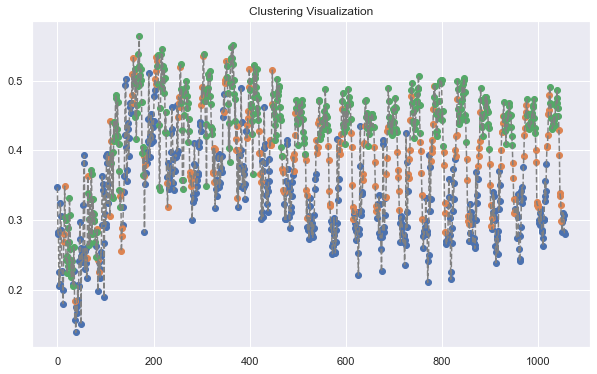

In [88]:
# Visualiztion of clustering 
plt.figure(figsize=(10, 6))

plt.plot(df_cluster.reset_index()["mourning dove"], color="grey", linestyle="--")
for i in range(3):
    series = df_cluster.reset_index().loc[kmeans.labels_ == i, "mourning dove"]
    plt.scatter(series.index, series.values)

plt.title("Clustering Visualization", fontsize=12)
# plt.xticks(range(len(df_cluster.index)), df_cluster.index, rotation=45, fontsize=1)
plt.show()

The first cluster (blue) can capture the lowest frequency (trough), the third (green) can capture the highest frequency (peak) whereas the third can capture the rest.

## <font face="Times New Roman">Relationship between Climate and Birds Migration</font>

Since the climate data we get is of hourly frequency, we did the aggregation to get daily data.  
For temperature and humdity we used average within the day; for precipitation we used sum within the day.

**<font face="Times New Roman">Aggregation</font>**

In [25]:
climate_data_raw = pd.read_csv('data/era5.csv')

climate_data_raw['date'] = pd.to_datetime(climate_data_raw['time']).dt.date
climate_data_raw['time'] = pd.to_datetime(climate_data_raw['time']).dt.time

climate_date = climate_data_raw.set_index('date')

climate_date = climate_date.groupby('date').aggregate({'temperature_2m (°F)': 'mean',
                                  'relativehumidity_2m (%)': 'mean',
                                      'precipitation (inch)': 'sum'})

climate_date.head()

,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch)
date,,,
2000-01-01,35.2375,91.875000,0.000
2000-01-02,42.4125,87.750000,0.000
2000-01-03,53.3750,84.916667,0.044
2000-01-04,53.9750,88.125000,0.288
2000-01-05,40.3375,65.958333,0.477


Visualizing the climate data

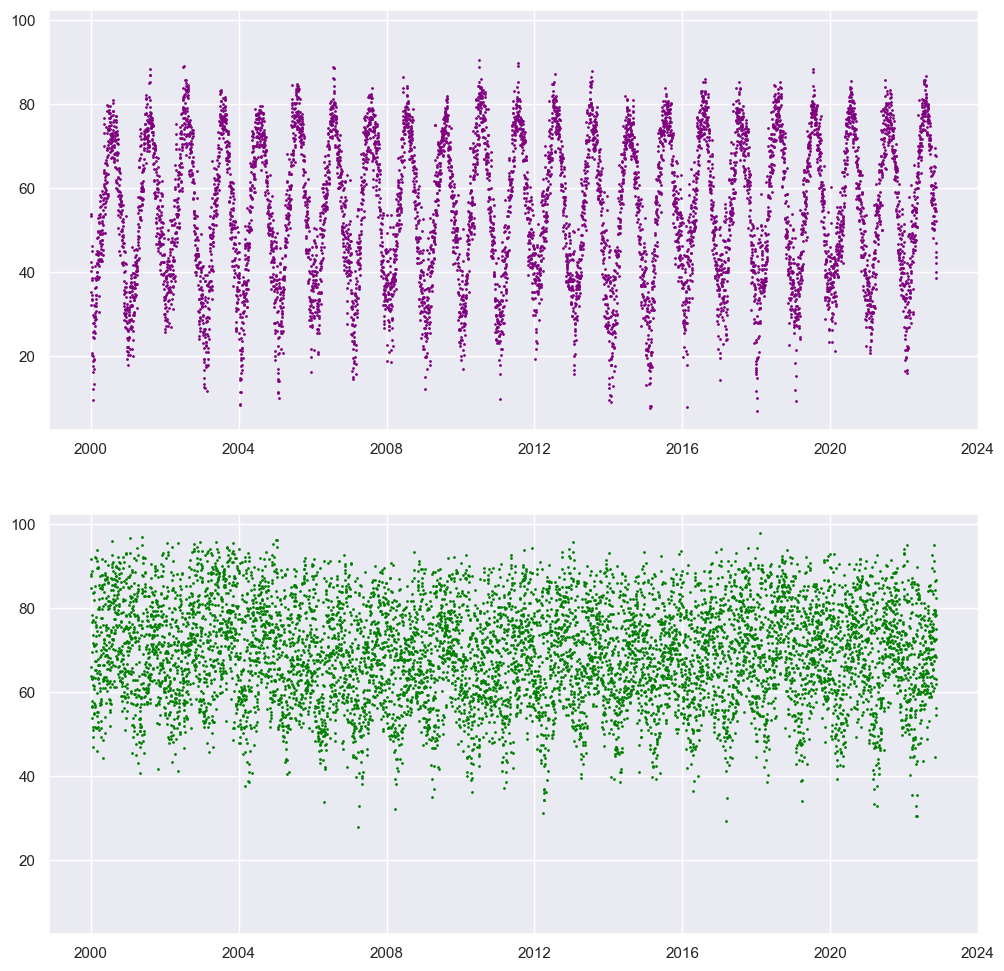

In [26]:
f, ax = plt.subplots(2,1, figsize = (12,12), sharey = True) 


ax[0].plot(climate_date['temperature_2m (°F)'], 'o', color = "purple", markersize =1)
ax[1].plot(climate_date['relativehumidity_2m (%)'], 'o', color = "green", markersize =1)


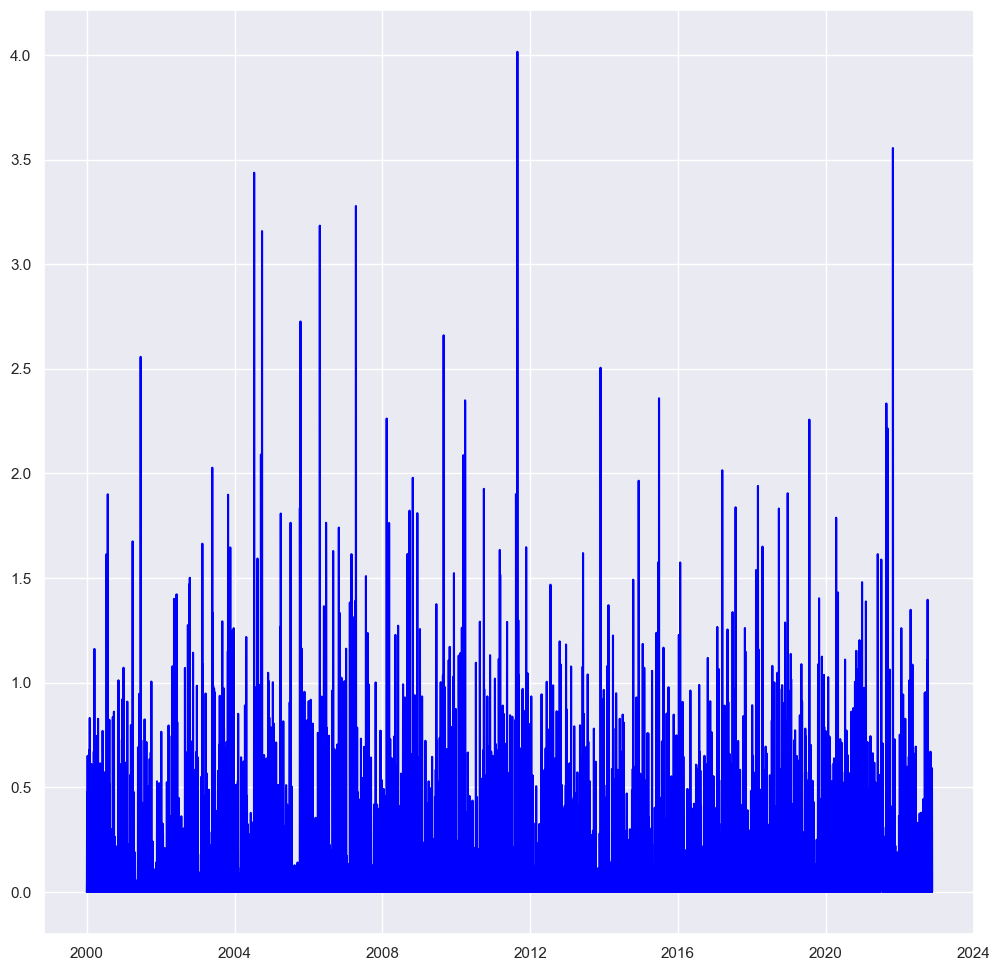

In [27]:
f2, ax2 = plt.subplots( figsize = (12,12), sharey = True) 

ax2.plot(climate_date["precipitation (inch)"], color = "blue")

In [73]:
# merged data
df_merged = pd.merge(
    left=df_migration_yoy, right=climate_date, left_index=True, right_index=True, how="inner"
)
print(df_merged.shape)
df_merged.head()

(1056, 842)


,week,sample size:,snow goose,ross's goose,swan goose,greater white-fronted goose,domestic goose sp. (domestic type),brant,barnacle goose,cackling goose,...,bermuda petrel,zone-tailed hawk,long-eared/short-eared owl,sulphur-bellied flycatcher,yellow-crowned bishop,dark-eyed junco/pine warbler,rose-breasted/black-headed grosbeak,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch)
date,,,,,,,,,,,,,,,,,,,,,
2000-01-07,Jan_1,150.0,0.020000,0.0000,0.0,0.000000,0.0,0.093333,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.145833,76.708333,0.00
2000-01-14,Jan_2,111.0,0.018018,0.0015,0.0,0.000000,0.0,0.090090,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.412500,56.875000,0.00
2000-01-21,Jan_3,99.0,0.010101,0.0000,0.0,0.000000,0.0,0.101010,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.775000,61.708333,0.02
2000-01-28,Jan_4,137.0,0.036496,0.0000,0.0,0.001500,0.0,0.116788,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.520833,54.875000,0.00
2000-02-07,Feb_1,124.0,0.024193,0.0000,0.0,0.008065,0.0,0.129032,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.029167,63.458333,0.00


Climate Data on visualization on the merged data set and scaled the frequecies by 100 to be on the same scale as the temperature and humidity data

In [83]:
df_merged_top_5 = df_merged
df_merged_top_5 = df_merged[['mourning dove', 'blue jay', 'black-capped chickadee', 'american robin', 'northern cardinal', 'temperature_2m (°F)', 'relativehumidity_2m (%)', "precipitation (inch)"]]
df_merged_scaled = df_merged[['mourning dove', 'blue jay', 'black-capped chickadee', 'american robin', 'northern cardinal', 'temperature_2m (°F)', 'relativehumidity_2m (%)', "precipitation (inch)"]]
df_merged_scaled[['mourning dove', 'blue jay', 'black-capped chickadee', 'american robin', 'northern cardinal']] = df_merged_scaled[['mourning dove', 'blue jay', 'black-capped chickadee', 'american robin', 'northern cardinal']].apply(lambda x: x*100)

df_merged_scaled
# df_merged_top_5

/var/folders/_n/mvw4h21n79b1ts9x78ng5cvw0000gn/T/ipykernel_44396/2759184822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_scaled[['mourning dove', 'blue jay', 'black-capped chickadee', 'american robin', 'northern cardinal']] = df_merged_scaled[['mourning dove', 'blue jay', 'black-capped chickadee', 'american robin', 'northern cardinal']].apply(lambda x: x*100)


,mourning dove,blue jay,black-capped chickadee,american robin,northern cardinal,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch)
date,,,,,,,,
2000-01-07,34.66667,42.00000,45.33333,14.66667,36.00000,38.145833,76.708333,0.000
2000-01-14,27.92793,33.33333,45.04505,7.20721,30.63063,20.412500,56.875000,0.000
2000-01-21,28.28283,34.34343,35.35354,13.13131,30.30303,17.775000,61.708333,0.020
2000-01-28,20.43796,23.35766,26.27737,8.75912,24.81752,13.520833,54.875000,0.000
2000-02-07,22.58065,25.80645,29.83871,12.90323,23.38710,32.029167,63.458333,0.000
...,...,...,...,...,...,...,...,...
2021-11-28,31.04845,45.50316,35.63442,26.38146,33.36574,36.116667,69.625000,0.032
2021-12-07,30.18754,42.18592,32.90986,23.81529,33.71648,42.816667,56.833333,0.072
2021-12-14,30.67695,41.23822,33.05484,21.85090,32.56213,45.066667,51.791667,0.000


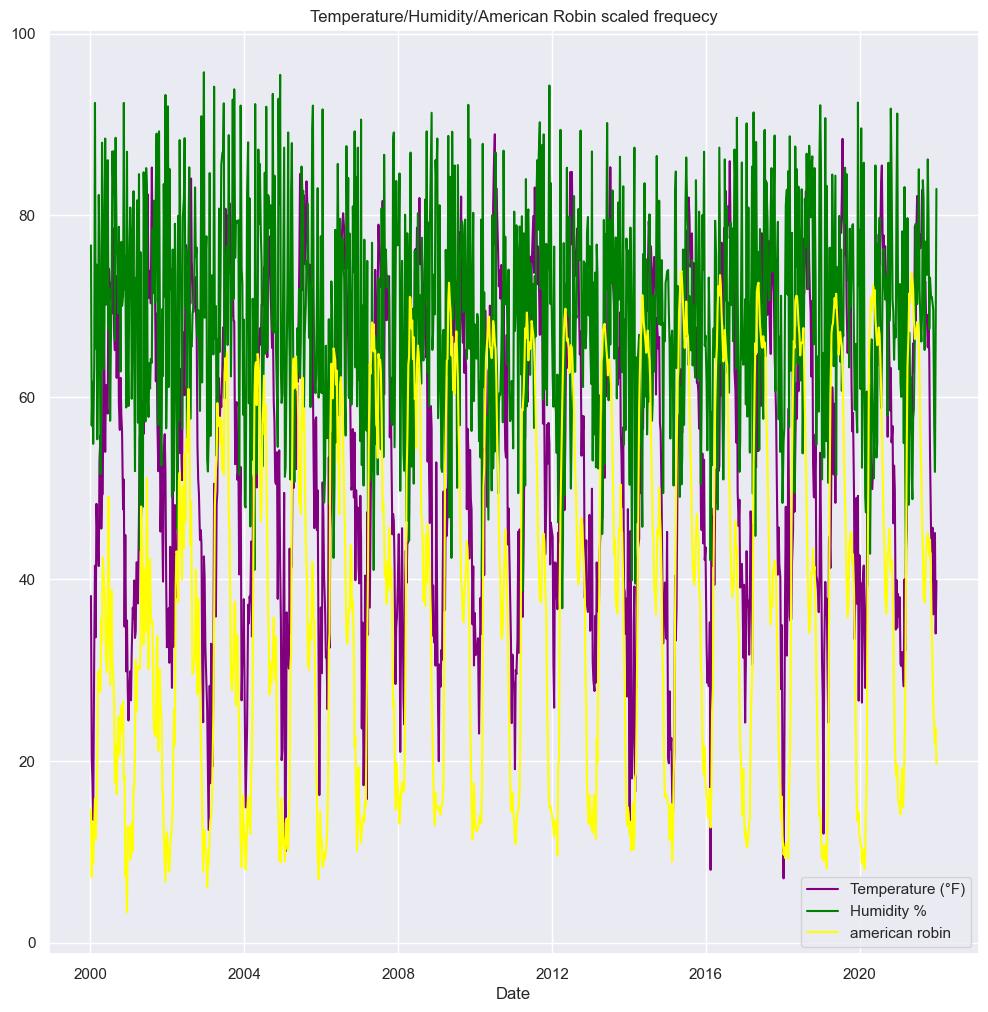

In [60]:
# temperature figure
fig, ax = plt.subplots(figsize = (12,12), dpi = 100) # figsize is a tuple (width, height) in inches

ax.plot(df_merged_scaled['temperature_2m (°F)'], color = "purple")
ax.plot(df_merged_scaled['relativehumidity_2m (%)'], color = "green")
ax.plot(df_merged_scaled['american robin'], color = "yellow")
ax.set_xlabel('Date')
ax.set_title('Temperature/Humidity/American Robin scaled frequecy');

ax.legend(['Temperature (°F)', 'Humidity %', 'american robin'])

To get more more information out of the visualization the data is resampled to get the average yearly values.

In [61]:
yearly_average_data = df_merged_scaled.resample('A').mean()
yearly_average_data.head()

,mourning dove,blue jay,black-capped chickadee,american robin,northern cardinal,temperature_2m (°F),relativehumidity_2m (%)
date,,,,,,,
2000-12-31,24.370851,25.648770,26.120250,24.080940,24.530674,52.122569,72.026910
2001-12-31,28.093845,29.948803,31.049011,26.745747,28.998010,54.417708,69.679688
2002-12-31,37.057746,37.051777,38.467780,32.843454,37.796257,54.223177,71.299479
2003-12-31,44.561483,41.909452,44.074860,35.045714,41.451168,51.783594,72.871528
2004-12-31,44.435235,42.521532,47.221833,34.130454,40.950003,52.950608,70.563368


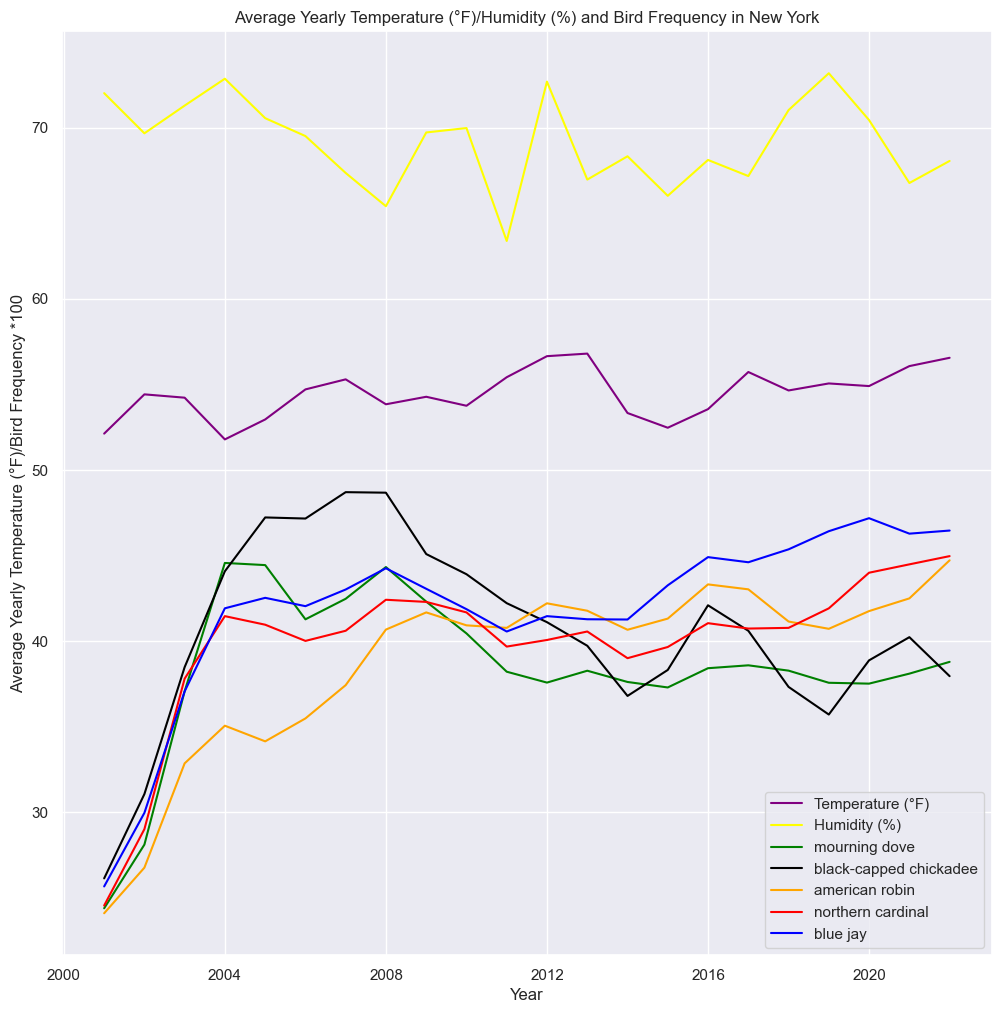

In [65]:
fig, ax = plt.subplots(figsize = (12,12), dpi = 100) # figsize is a tuple (width, height) in inches

ax.plot(yearly_average_data['temperature_2m (°F)'], color = "purple")
ax.plot(yearly_average_data['relativehumidity_2m (%)'], color = "yellow")
ax.set_xlabel('Year')
ax.set_ylabel('Average Yearly Temperature (°F)/Bird Frequency *100')
ax.set_title('Average Yearly Temperature (°F)/Humidity (%) and Bird Frequency in New York');

ax.plot(yearly_average_data['mourning dove'], color = 'green') # different ways of controlling the way the marker looks
ax.plot(yearly_average_data['black-capped chickadee'], color = 'black')
ax.plot(yearly_average_data['american robin'], color = 'orange')
ax.plot(yearly_average_data['northern cardinal'], color = 'red')
ax.plot(yearly_average_data['blue jay'], color = 'blue')

ax.legend(['Temperature (°F)', 'Humidity (%)', 'mourning dove', 'black-capped chickadee', 'american robin', 'northern cardinal', 'blue jay'])



See how the top 5 bird activity relates to the average yearly sum of precipitation

In [85]:
df_merged_top_5

yearly_average_humidity = df_merged_top_5.resample('A').mean()
yearly_average_humidity.head()


,mourning dove,blue jay,black-capped chickadee,american robin,northern cardinal,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch)
date,,,,,,,,
2000-12-31,0.243709,0.256488,0.261202,0.240809,0.245307,52.122569,72.026910,0.109812
2001-12-31,0.280938,0.299488,0.310490,0.267457,0.289980,54.417708,69.679688,0.063417
2002-12-31,0.370577,0.370518,0.384678,0.328435,0.377963,54.223177,71.299479,0.125875
2003-12-31,0.445615,0.419095,0.440749,0.350457,0.414512,51.783594,72.871528,0.151750
2004-12-31,0.444352,0.425215,0.472218,0.341305,0.409500,52.950608,70.563368,0.139000


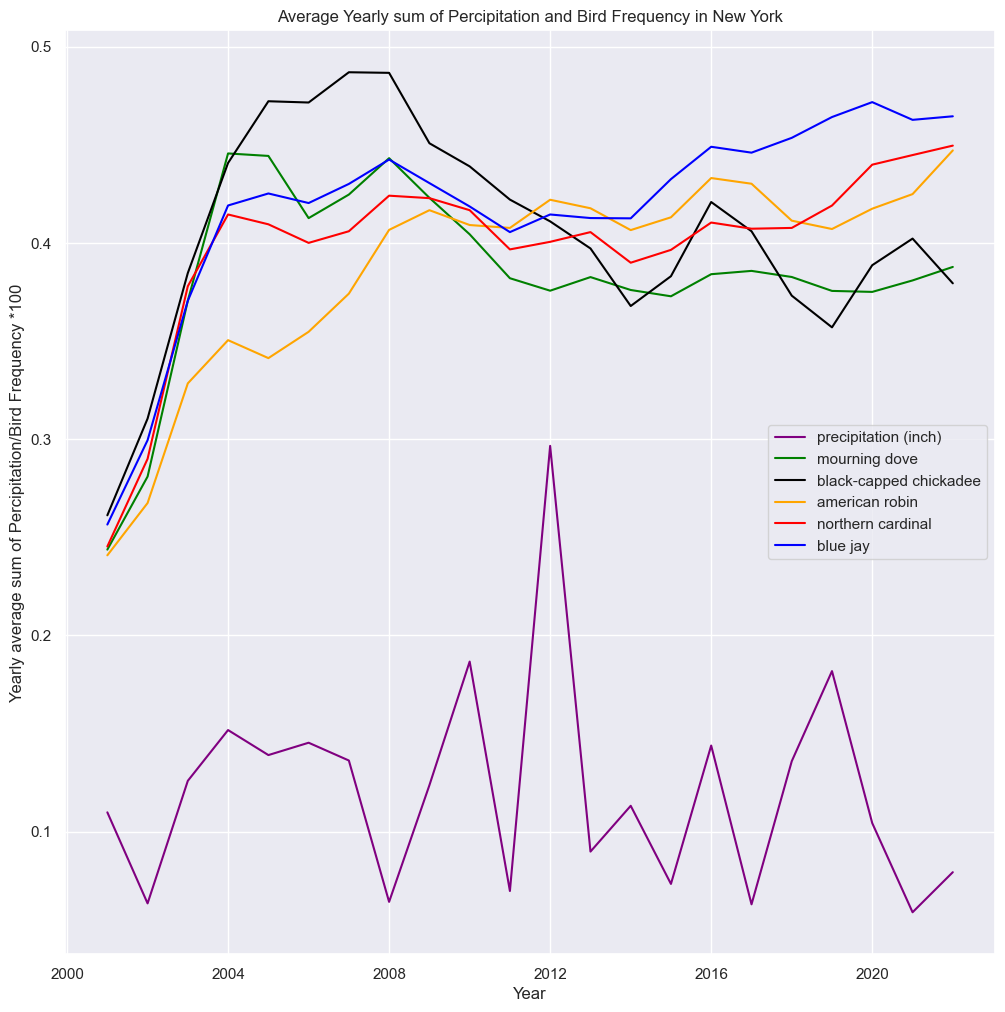

In [87]:
fig, ax = plt.subplots(figsize = (12,12), dpi = 100) # figsize is a tuple (width, height) in inches

ax.plot(yearly_average_humidity['precipitation (inch)'], color = "purple")
ax.set_xlabel('Year')
ax.set_ylabel('Yearly average sum of Percipitation/Bird Frequency *100')
ax.set_title('Average Yearly sum of Percipitation and Bird Frequency in New York');

ax.plot(yearly_average_humidity['mourning dove'], color = 'green') # different ways of controlling the way the marker looks
ax.plot(yearly_average_humidity['black-capped chickadee'], color = 'black')
ax.plot(yearly_average_humidity['american robin'], color = 'orange')
ax.plot(yearly_average_humidity['northern cardinal'], color = 'red')
ax.plot(yearly_average_humidity['blue jay'], color = 'blue')

ax.legend(['precipitation (inch)', 'mourning dove', 'black-capped chickadee', 'american robin', 'northern cardinal', 'blue jay'])


There does not seem to be any patterns with percipition and the top 5 birds migration activity.

Train a linear regression model using temperature, humidity and precipitation to predict frequency of Mourning Dove.

In [92]:
train_x = df_merged[['temperature_2m (°F)', 'relativehumidity_2m (%)', 'precipitation (inch)']].iloc[:800]
test_x = df_merged[['temperature_2m (°F)', 'relativehumidity_2m (%)', 'precipitation (inch)']].iloc[800:]
train_y  = df_merged[["mourning dove"]].iloc[:800]
test_y = df_merged[["mourning dove"]].iloc[800:]

clf = LinearRegression().fit(train_x, train_y)
y_pred = clf.predict(test_x)

**<font face="Times New Roman">Out-of-sample prediction</font>**

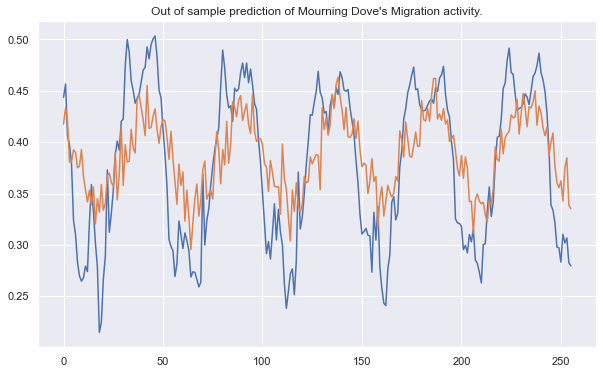

In [97]:
plt.figure(figsize=(10, 6))

plt.title("Out of sample prediction of Mourning Dove's Migration activity.")
plt.plot(test_y.values)
plt.plot(y_pred)

plt.show()